In [16]:
# Import libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import keras
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [17]:
# Loading the tokenizer to generate tokens and model to perform sentiment analysis
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
# Override how Pandas Datareader reads data
yf.pdr_override()

In [19]:
# Start date, end date and the stock we want to predict
today = datetime.now()
start = datetime(today.year - 2, today.month, today.day)
end = datetime(today.year, today.month, today.day)
print(start)
print(end)

2022-06-10 00:00:00
2024-06-10 00:00:00


In [20]:
# Define the list of stocks you want to download
stocks = ["ZOMATO.NS", "RELIANCE.NS", "TCS.NS"]

# Create an empty DataFrame to hold all the data
all_stock_data = pd.DataFrame()

# Loop through each stock and download the data
for stock in stocks:
    # Download data from Yahoo Finance
    df = yf.download(stock, start=start, end=end)

    # Ticker for searching news
    stockraw = stock[:-3]

    # Getting data using html requests
    link = f"https://news.google.com/search?q={stockraw}&hl=en-IN&gl=IN&ceid=IN%3Aen"
    req = Request(link, headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    soup = BeautifulSoup(webpage, 'html.parser')

    # Extract titles and dates
    titles = soup.find_all('a', class_='JtKRv')
    datetimes = soup.find_all('time', class_='hvbAAd')

    # Create lists to store extracted data
    dates_list = []
    titles_list = []

    for title, datetime_tag in zip(titles, datetimes):
        # Remove leading/trailing whitespace from title
        title_text = title.text.strip()
        datetime_str = datetime_tag['datetime']

        # Parse datetime string
        formatted_datetime = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%S%z')

        # Append data to respective lists
        dates_list.append(formatted_datetime.date())
        titles_list.append(title_text)

    # Create DataFrame
    df2 = pd.DataFrame({'Date': dates_list, 'Headline': titles_list})

    # Finding the encodings for each of the headlines found
    encoded_headlines = []
    for headline in df2['Headline']:
        encoded_headline = tokenizer(headline, padding=True, truncation=True, return_tensors='pt')
        encoded_headlines.append(encoded_headline)

    # Finding the sentiment scores of each headline
    # Initialize an empty list to store the tweet sentiments
    headline_sentiments = []

    # Iterate over the encoded tweets
    for encoded_headline in encoded_headlines:
        # Pass the encoded tweet to the model
        output = model(**encoded_headline)

        # Extract the scores
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)

        # Calculate the sentiment score between -1 and 1
        sentiment_score = scores[2] - scores[0]

        # Append the sentiment score to the list
        headline_sentiments.append(sentiment_score)

    # Add the tweet sentiments as a new column to the DataFrame
    df2['Sentiments'] = headline_sentiments

    # Convert 'Date' column to datetime if it's not already
    df2['Date'] = pd.to_datetime(df2['Date'])

    # Group by 'Date' and calculate the average sentiment for each day
    average_sentiments = df2.groupby('Date')['Sentiments'].mean().reset_index()

    # Merge the dataframes on the 'Date' column with a left join to keep all rows from df
    merged_df = pd.merge(df, average_sentiments, on='Date', how='left')

    # Fill missing sentiment scores with 0
    merged_df['Sentiments'].fillna(0, inplace=True)

    # If you want to ensure that 'Sentiments' column is of numeric type
    merged_df['Sentiments'] = pd.to_numeric(merged_df['Sentiments'])

    # Add a column for the stock ticker
    merged_df['Stock'] = stock

    # Add all data to the following dataframe
    all_stock_data = pd.concat([all_stock_data, merged_df])

# Reset the index
all_stock_data.reset_index(inplace=True)

print(all_stock_data)

[*********************100%%**********************]  1 of 1 completed
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


      index       Date         Open         High          Low        Close  \
0         0 2022-06-10    67.300003    69.699997    66.500000    69.000000   
1         1 2022-06-13    67.500000    68.300003    65.400002    67.500000   
2         2 2022-06-14    64.199997    70.750000    64.000000    70.000000   
3         3 2022-06-15    70.650002    71.900002    68.949997    70.199997   
4         4 2022-06-16    72.000000    72.000000    66.099998    67.199997   
...     ...        ...          ...          ...          ...          ...   
1468    486 2024-06-03  3732.800049  3751.550049  3696.000000  3702.850098   
1469    487 2024-06-04  3700.000000  3745.000000  3591.500000  3715.000000   
1470    488 2024-06-05  3716.000000  3783.800049  3700.000000  3746.449951   
1471    489 2024-06-06  3781.000000  3839.899902  3741.500000  3830.399902   
1472    490 2024-06-07  3837.300049  3915.000000  3837.300049  3893.949951   

        Adj Close    Volume  Sentiments      Stock  
0       69

In [21]:
# Isolating features for training
cols = list(all_stock_data)[2:10]

# Storing all data to be fed to the model
df_for_training = all_stock_data[cols]

df_for_training

,Open,High,Low,Close,Adj Close,Volume,Sentiments,Stock
0,67.300003,69.699997,66.500000,69.000000,69.000000,42040372,0.000000,ZOMATO.NS
1,67.500000,68.300003,65.400002,67.500000,67.500000,34863276,0.000000,ZOMATO.NS
2,64.199997,70.750000,64.000000,70.000000,70.000000,66677006,0.000000,ZOMATO.NS
3,70.650002,71.900002,68.949997,70.199997,70.199997,33246369,0.000000,ZOMATO.NS
4,72.000000,72.000000,66.099998,67.199997,67.199997,41879881,0.000000,ZOMATO.NS
...,...,...,...,...,...,...,...,...
1468,3732.800049,3751.550049,3696.000000,3702.850098,3702.850098,2156773,0.000000,TCS.NS
1469,3700.000000,3745.000000,3591.500000,3715.000000,3715.000000,3395997,-0.579817,TCS.NS
1470,3716.000000,3783.800049,3700.000000,3746.449951,3746.449951,2799670,0.000000,TCS.NS
1471,3781.000000,3839.899902,3741.500000,3830.399902,3830.399902,4328036,0.009724,TCS.NS


In [22]:
# Initialize OneHotEncoder for the 'Stock' column
one_hot_encoder = OneHotEncoder(sparse_output=False)
stock_encoded = one_hot_encoder.fit_transform(df_for_training[['Stock']])

# Create a DataFrame with the one-hot encoded columns
stock_encoded_df = pd.DataFrame(stock_encoded, columns=one_hot_encoder.get_feature_names_out(['Stock']))

# Concatenate the one-hot encoded columns with the original data
df_for_trainin = pd.concat([df_for_training.reset_index(drop=True), stock_encoded_df], axis=1)

# Drop the original 'Stock' column as it's now one-hot encoded
df_for_trainin.drop('Stock', axis=1, inplace=True)

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Select only the numerical columns for scaling
numerical_cols = list(df_for_training)[0:7]

# Fit and transform the numerical data
scaled_numerical_data = scaler.fit_transform(df_for_trainin[numerical_cols])

# Create a new DataFrame for the scaled data
df_scaled = df_for_trainin.copy()
df_scaled[numerical_cols] = scaled_numerical_data
print(df_scaled)
print(df_scaled.shape)

          Open      High       Low     Close  Adj Close    Volume  Sentiments  \
0     0.006336  0.006009  0.006261  0.006547   0.006595  0.070104    0.495380   
1     0.006384  0.005676  0.005996  0.006188   0.006233  0.058136    0.495380   
2     0.005594  0.006258  0.005657  0.006786   0.006836  0.111186    0.495380   
3     0.007139  0.006532  0.006854  0.006834   0.006884  0.055439    0.495380   
4     0.007462  0.006555  0.006165  0.006116   0.006161  0.069836    0.495380   
...        ...       ...       ...       ...        ...       ...         ...   
1468  0.884427  0.880485  0.883715  0.876388   0.882822  0.003596    0.495380   
1469  0.876569  0.878929  0.858452  0.879297   0.885752  0.005663    0.121200   
1470  0.880402  0.888145  0.884682  0.886825   0.893335  0.004669    0.495380   
1471  0.895973  0.901469  0.894715  0.906920   0.913578  0.007217    0.501655   
1472  0.909460  0.919306  0.917875  0.922132   0.928902  0.007591    0.691800   

      Stock_RELIANCE.NS  St

In [23]:
# Function to create sequences
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['Open', 'Close']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)

In [24]:
# Dataset splitting
SPLIT = 0.85
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]
print(xVal.shape)
print(yVal.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1453, 20, 10)
(1453, 2)
(1235, 20, 10)
(1235, 2)
(218, 20, 10)
(218, 2)


In [25]:
# Building the model
multivariate_lstm = keras.Sequential()
multivariate_lstm.add(keras.layers.LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
multivariate_lstm.add(keras.layers.Dropout(0.2))
multivariate_lstm.add(keras.layers.Dense(2, activation='linear'))
multivariate_lstm.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
multivariate_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               168800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
Total params: 169202 (660.95 KB)
Trainable params: 169202 (660.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# Fitting the data to the model
history = multivariate_lstm.fit(X_train, y_train, epochs=100)

Epoch 1/100
39/39 [==============================] - 3s 31ms/step - loss: 0.0230 - MAE: 0.0958
Epoch 2/100
39/39 [==============================] - 1s 32ms/step - loss: 0.0034 - MAE: 0.0416
Epoch 3/100
39/39 [==============================] - 1s 33ms/step - loss: 0.0026 - MAE: 0.0359
Epoch 4/100
39/39 [==============================] - 3s 80ms/step - loss: 0.0025 - MAE: 0.0345
Epoch 5/100
39/39 [==============================] - 3s 75ms/step - loss: 0.0021 - MAE: 0.0309
Epoch 6/100
39/39 [==============================] - 2s 58ms/step - loss: 0.0021 - MAE: 0.0315
Epoch 7/100
39/39 [==============================] - 2s 60ms/step - loss: 0.0018 - MAE: 0.0285
Epoch 8/100
39/39 [==============================] - 3s 68ms/step - loss: 0.0016 - MAE: 0.0268
Epoch 9/100
39/39 [==============================] - 3s 70ms/step - loss: 0.0017 - MAE: 0.0283
Epoch 10/100
39/39 [==============================] - 4s 98ms/step - loss: 0.0016 - MAE: 0.0264
Epoch 11/100
39/39 [=============================

7/7 [==============================] - 1s 28ms/step


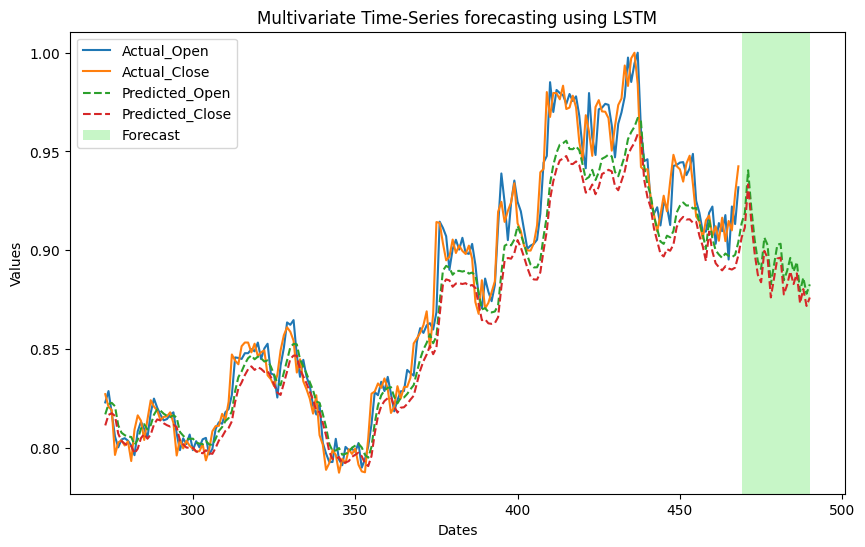

In [27]:
# Reload the data with the date index
dataFrame = merged_df

# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

d = {
	'Predicted_Open': predicted_values[:, 0],
	'Predicted_Close': predicted_values[:, 1],
	'Actual_Open': y_test[:, 0],
	'Actual_Close': y_test[:, 1],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index

fig, ax = plt.subplots(figsize=(10, 6))
# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Multivariate Time-Series forecasting using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()